In [6]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import copy

In [2]:
df = pd.read_csv("[data] final.csv")

In [4]:
liwc_vars = ["WC", "emo_pos", "emo_neg", "moral", "prosocial", "conflict", "power", "politic", "tech", "relig", "health", "reward", "risk"]

vars_oi = ["Video", "Image", "OpenEnded", "CloseEnded", "Engagement", "Specificity"] + [x for x in liwc_vars if x not in ['Segment']]
# vars_oi = ["Specificity"]

formula = f"Increase ~ {'+'.join(vars_oi)}"
print(formula)

model_df = df.dropna()
model_df['Engagement'] = model_df.groupby('Study')['Engagement'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

model_df['Specificity'] = model_df.groupby('Study')['Specificity'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


md = smf.mixedlm(formula, model_df, groups=model_df["Study"])
mdf = md.fit()

print(mdf.summary())


Increase ~ Video+Image+OpenEnded+CloseEnded+Engagement+Specificity+WC+emo_pos+emo_neg+moral+prosocial+conflict+power+politic+tech+relig+health+reward+risk
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Increase  
No. Observations: 435     Method:             REML      
No. Groups:       16      Scale:              20.8573   
Min. group size:  8       Log-Likelihood:     -1306.9415
Max. group size:  68      Converged:          Yes       
Mean group size:  27.2                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.894    1.481  1.279 0.201 -1.008  4.796
Video          0.339    0.573  0.591 0.554 -0.784  1.462
Image          0.016    0.073  0.221 0.825 -0.126  0.158
OpenEnded      0.067    0.104  0.645 0.519 -0.136  0.270
CloseEnded     0.040    0.059  0.679 0.497 -0.075  0.155


/var/folders/r2/jx65nzrn7x13j53p2wvrlt6w0000gn/T/ipykernel_7822/1179578842.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Engagement'] = model_df.groupby('Study')['Engagement'].transform(
/var/folders/r2/jx65nzrn7x13j53p2wvrlt6w0000gn/T/ipykernel_7822/1179578842.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['Specificity'] = model_df.groupby('Study')['Specificity'].transform(


In [7]:
# Rename variables in model_df and mdf using the renamer dictionary
renamer = {
    "relig": "Faith",
    "conflict": "Interpersonal conflict",
    "Video": "Number of videos",
    "OpenEnded": "Open-ended questions",
    "emo_pos": "Positive emotion",
    "Image": "Number of images",
    "emo_neg": "Negative emotion",
    "power": "Power",
    "reward": "Reward",
    "WC": "Word Count",
    "moral": "Moralization",
    "health": "Health",
    "CloseEnded": "Closed-ended questions",
    "prosocial": "Prosocial behavior",
    "risk": "Risk",
    "politic": "Politics",
    "tech": "Technology",
    "bVideo[T.True]": "Contains a video",
    "bImage[T.True]": "Contains an image"
}

model_df = model_df.rename(columns=renamer)
vars_oi = [renamer.get(var, var) for var in vars_oi]

# Create a copy of the fitted model results
mdf_renamed = copy.deepcopy(mdf)

# Rename the parameter names in all relevant attributes
original_params = list(mdf.params.index)
renamed_params = [renamer.get(param, param) for param in original_params]

# Update the parameter names in the model results
mdf_renamed.params.index = renamed_params
mdf_renamed.pvalues.index = renamed_params
mdf_renamed.conf_int().index = renamed_params
mdf_renamed.bse.index = renamed_params
mdf_renamed.tvalues.index = renamed_params

# Replace the original
mdf = mdf_renamed

/var/folders/r2/jx65nzrn7x13j53p2wvrlt6w0000gn/T/ipykernel_7822/3949004434.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.pointplot(y='Variable', x='Beta', data=coef_df_sorted, palette=color_dict, linestyles='none', order=sorted_cond_names)


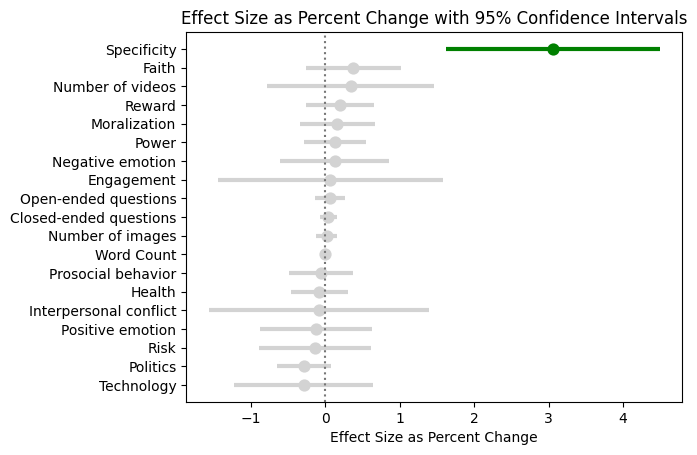

In [11]:
# Extract effect size (percent increase) and confidence intervals

coefficients = mdf.params
conf_intervals = mdf.conf_int()

coef_df = conf_intervals.reset_index()
coef_df.columns = ['Variable', 'Lower CI', 'Upper CI']
coef_df['Beta'] = coefficients.values
coef_df["P-value"] = np.array(mdf.pvalues)

coef_df = coef_df[~coef_df["Variable"].isin(["Intercept", "Group Var"])]

coef_df['Variable'] = coef_df['Variable'].replace(renamer)

coef_df_sorted = coef_df.sort_values('Beta', ascending=False)


# Determine significance based on p-values
alpha = 0.05
coef_df_sorted['Significant'] = np.where(coef_df_sorted['P-value'] < alpha, 'Significant', 'Not Significant')

def assign_color(row):
    if row['Significant'] == 'Significant':
        if row['Beta'] < 0:
            return '#ab3939'  # Negative significant (red)
        else:
            return  'green'  # Positive significant (green)
    else:
        return 'lightgray'  # Non-significant (gray)

coef_df_sorted['color'] = coef_df_sorted.apply(assign_color, axis=1)

sorted_cond_names = coef_df_sorted['Variable'].values
color_dict = dict(zip(coef_df_sorted['Variable'], coef_df_sorted['color']))
ax = sns.pointplot(y='Variable', x='Beta', data=coef_df_sorted, palette=color_dict, linestyles='none', order=sorted_cond_names)

# Add confidence interval bars instead of standard error bars
for i, row in coef_df_sorted.iterrows():
    plt.errorbar(
        row['Beta'],
        coef_df_sorted.index.get_loc(i),
        xerr=[[row['Beta'] - row['Lower CI']], [row['Upper CI'] - row['Beta']]],
        fmt='none', c=row["color"], linewidth=3
    )

plt.axvline(x=0, c="#777777", ls=":")

plt.ylabel("")
plt.xlabel("Effect Size as Percent Change")
plt.title('Effect Size as Percent Change with 95% Confidence Intervals')

plt.show()

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only the independent variables used in the model
X = model_df[vars_oi]

# If any variables are boolean, convert them to float for VIF calculation
X = X.astype(float)

vif_data = []
for i in range(X.shape[1]):
    vif = variance_inflation_factor(X.values, i)
    vif_data.append({'Variable': X.columns[i], 'VIF': vif})

vif_df = pd.DataFrame(vif_data)
print(vif_df)

                  Variable       VIF
0         Number of videos  2.449899
1         Number of images  1.494057
2     Open-ended questions  1.657832
3   Closed-ended questions  2.148266
4               Engagement  4.214720
5              Specificity  2.960834
6               Word Count  2.643922
7         Positive emotion  1.882394
8         Negative emotion  1.544921
9             Moralization  1.533669
10      Prosocial behavior  2.390988
11  Interpersonal conflict  2.215781
12                   Power  4.073544
13                Politics  2.680407
14              Technology  1.829358
15                   Faith  1.584416
16                  Health  1.688127
17                  Reward  1.453763
18                    Risk  1.741888


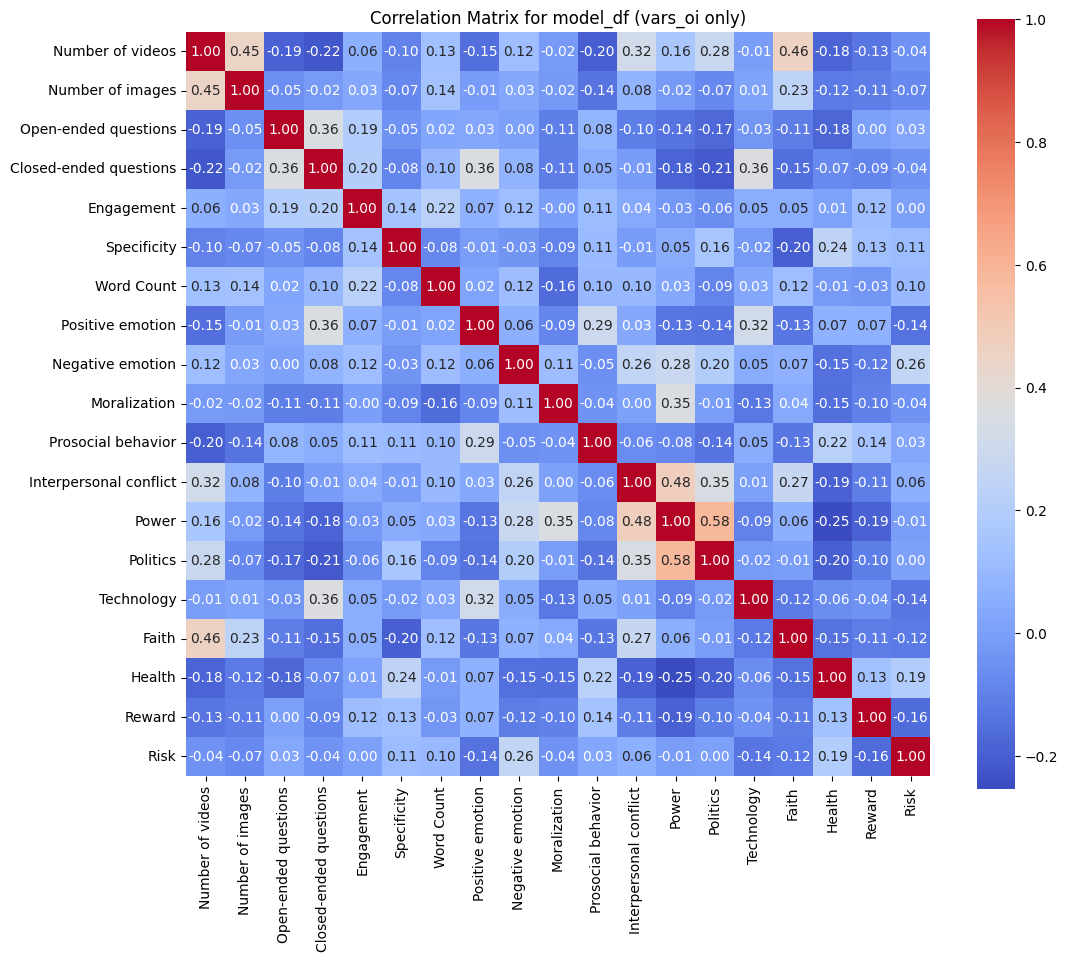

In [12]:
# Plot the correlation matrix for model_df using only vars_oi columns
corr = model_df[vars_oi].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix for model_df (vars_oi only)")
plt.show()